# Diffusion Map Abdominal Fetal Electrocardiogram Filtering

This project involves recording the fetal electrocardiogram (ECG) non-invasively by attaching electrodes to the maternal abdomen. This approach contrasts with the direct fetal ECG, which requires fetal electrode attachment. A significant challenge in this method is the contamination of the fetal ECG signal with maternal heart waves. The project's primary objective is to effectively filter out the fetal heartbeat from the abdominal maternal ECG signals. All signals in this study are sampled at a 1 kHz frequency with a 16-bit resolution.

A diffusion map, as introduced by Coifman and Lafon in 2006, is a powerful dimensionality reduction technique in data analysis and machine learning. It's particularly adept at uncovering the manifold structure in high-dimensional datasets. This method utilizes diffusion processes to create a geometric framework for data representation. In our project, we'll leverage the diffusion map's capability to discern geometric properties. This will enable us to differentiate between maternal and fetal heartbeats, focusing on the size and shape distinctions of each heartbeat.

In [1]:
require(edf)

Loading required package: edf



In [2]:
# reading in the Abdominal Fetal Electrocardiogram data
df = read.edf("r01.edf")$signal$Abdomen_3$data

In [3]:
# The data is quite long when sampled every millisecond, we will only be selecting a portion of the data.
skip = 2
init = 1000
len = 1500
# down sample by a factor of 2, skip ever other entry
t = seq(init,init + len*skip,skip)
data = df[t]
# normalize the signal to be in between [-1,1]
data = data / max( max(data),abs(min(data)))
length(data)

[1] 1501

The Diffusion Map algorithm faces limitations in scaling efficiently with large datasets, both in terms of memory usage and computational speed. To address this, it is advisable to partition the dataset into smaller subsets for processing. Additionally, in our approach, we enhance efficiency by sampling the dataset at alternate intervals, effectively skipping every other signal reading.

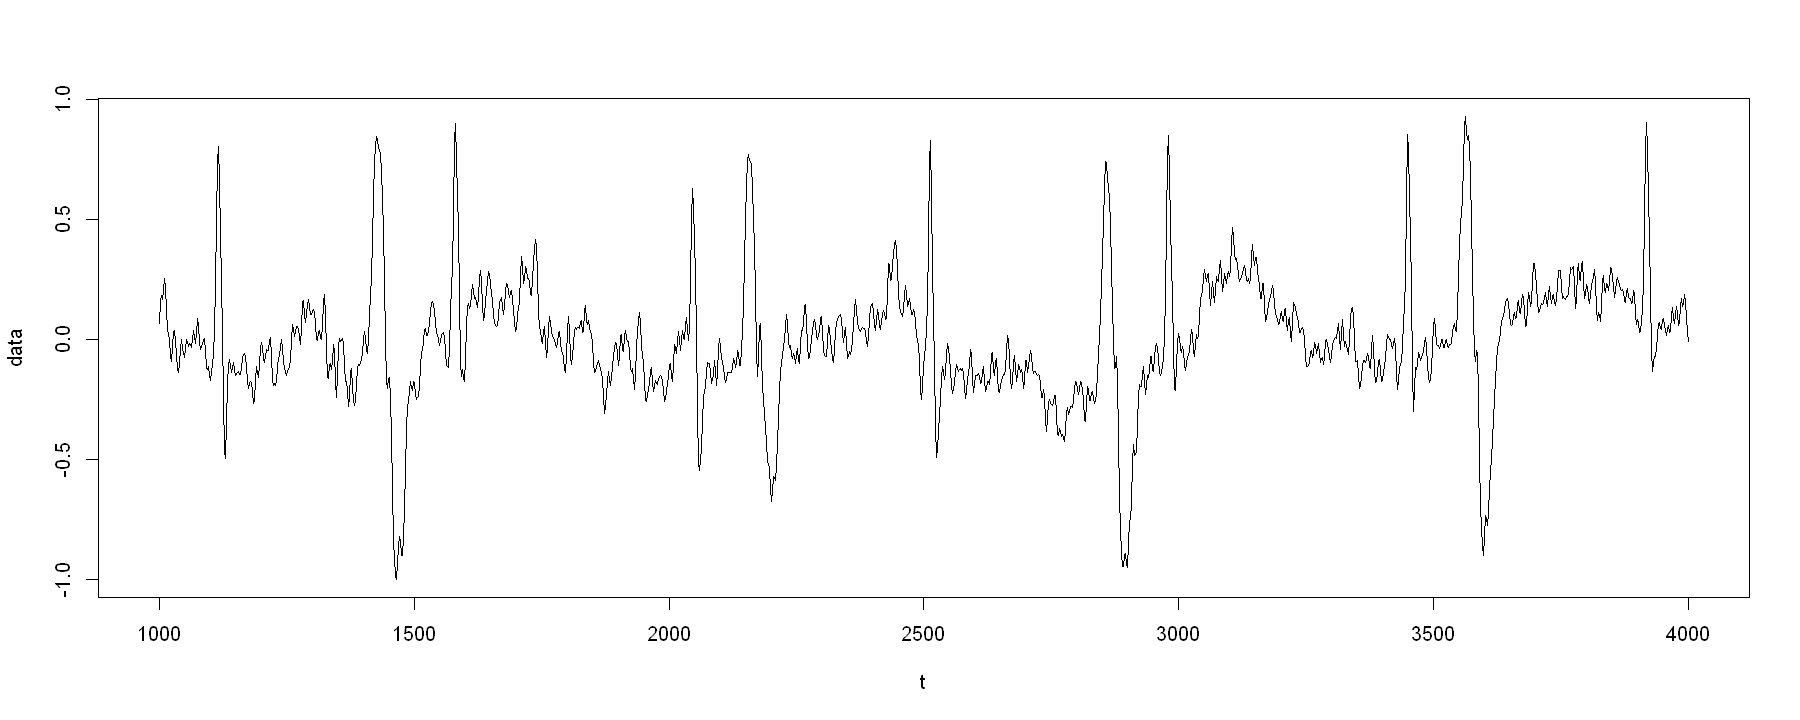

In [4]:
options(repr.plot.width = 15, repr.plot.height = 6)
plot(t,data,type = "l")

In this project, we analyze an Electrocardiogram (ECG) containing overlapping electrical pulses from both maternal and fetal heartbeats, resulting in seemingly aperiodic signal spikes. Using the Diffusion Map technique, we aim to distinguish these two signals. Our analysis identifies four large peaks with extensive periods and seven smaller peaks with shorter bandwidths and periods. The Diffusion Map's ability to discern geometric properties like peak size and width is pivotal here. We'll first isolate the stronger maternal signal, then proceed to extract the fetal ECG signal.

In [5]:
# We begin Diffusion Map with the construction of a Markov chain, 
# where transition probabilities between data points are defined based on their similarity.
gen_P <- function(f,sigma,BandWidth){ 
  P = matrix(0,nrow = length(f)-2* BandWidth ,ncol = length(f) - 2*BandWidth) 
  weight = c(1:(BandWidth+1) , BandWidth:1) / (BandWidth+1)
       for(i in (BandWidth+1):(length(f)-BandWidth)  ){
          for(j in i:(length(f)-BandWidth) ){
            # generating distance using Gaussian Kernel 
              # We will be using a weighted Gaussian kernel based on nearby 
             SS = sum((f[(i-BandWidth):(i+BandWidth)] - 
                         f[(j-BandWidth):(j+BandWidth)])^2 * weight^2)
              P[i-BandWidth,j-BandWidth] = exp(-SS/sigma^2/2)
        }
      }
   P = P + t(P) - diag(rep(2,length(f)-2*BandWidth))
  diag(1/rowSums(P)) %*% P
}
# Selecting the second largest eigenvalue's corresponding eigenvector for smooth filtering
filter_dm <-function(data,Sig,BandWidth){
  P = gen_P(data,Sig,BandWidth)
  dm = eigen(P)
  dm$vectors[,2]
}


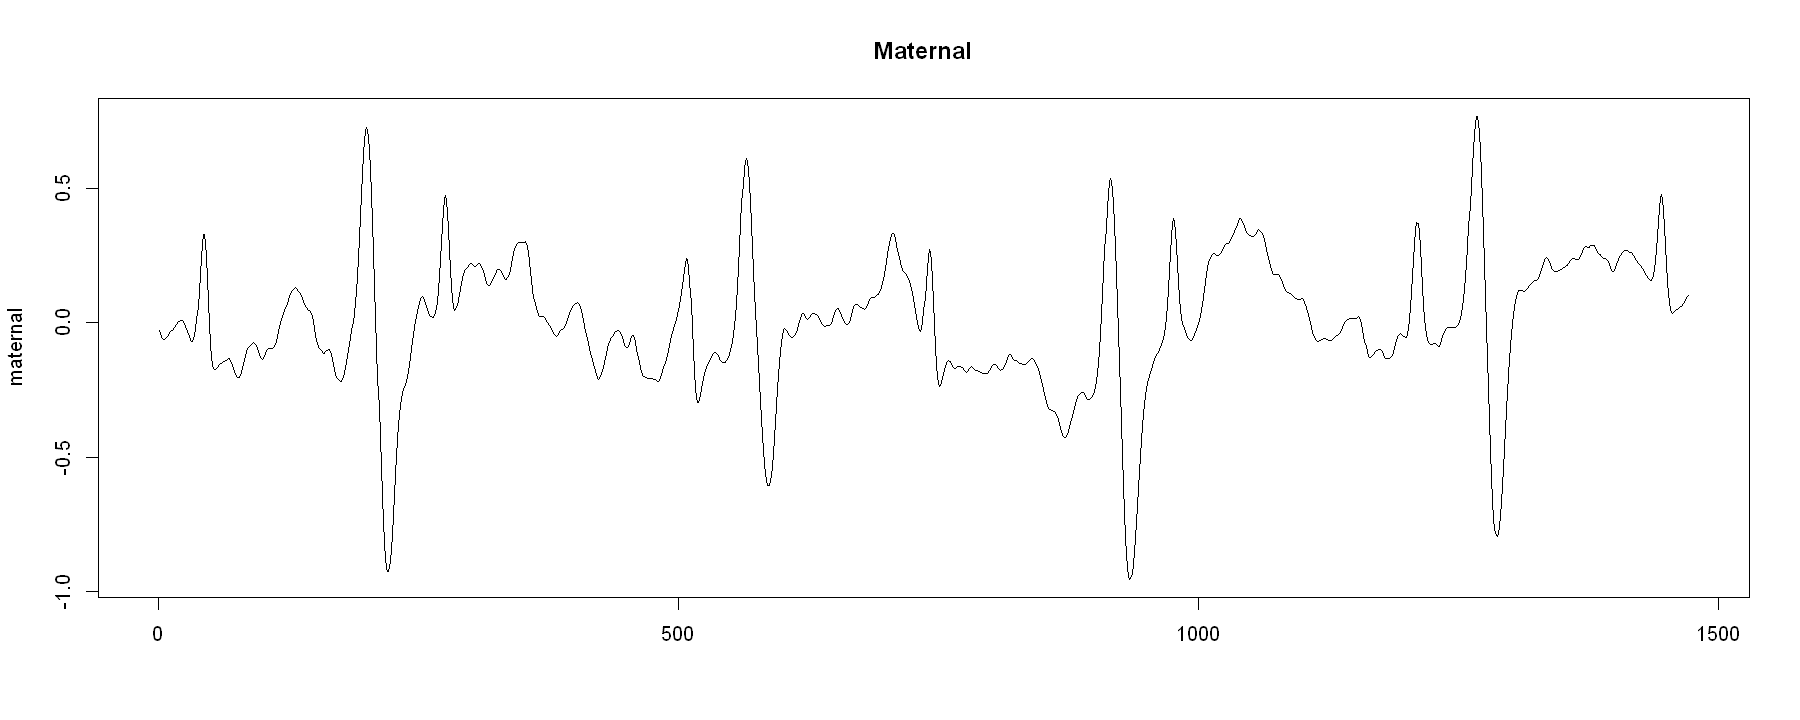

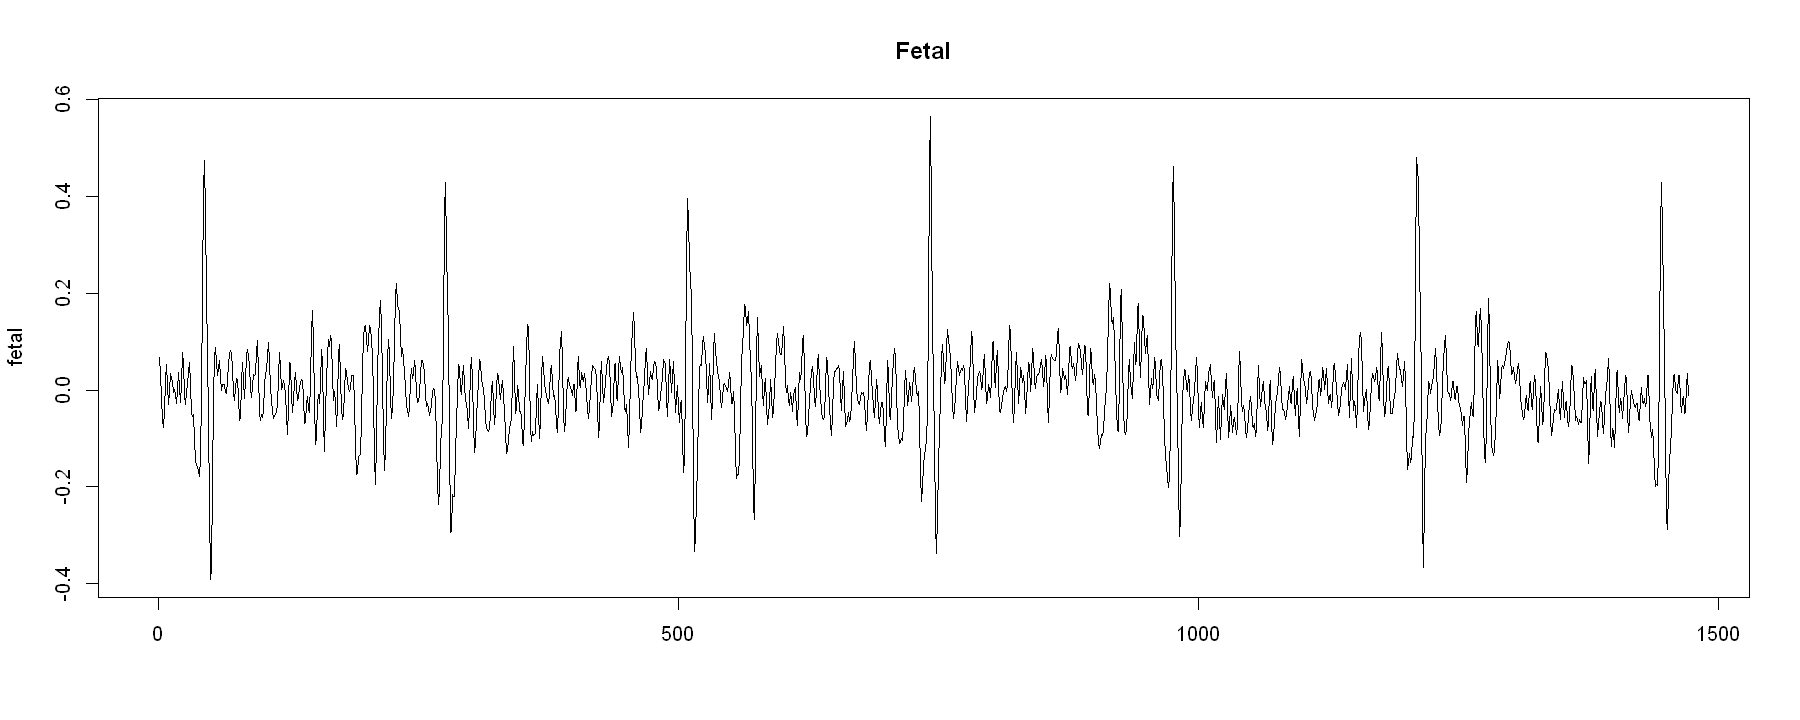

In [6]:
# filter for specific bandwidth and inverse precision parameter of the weighted Gaussian kernel
BandWidth = 15
sig = 4
filter1 = filter_dm(data,sig,BandWidth)
# fit the filter to the data set by finding a linear transformation minimizing the square distance between data
lm_coef = lm( data[(1+BandWidth):(length(data)-BandWidth) ]~ filter1 )$coefficients
maternal = lm_coef[1] + lm_coef[2]* filter1
fetal = data[(1+BandWidth):(length(data)-BandWidth) ] - maternal
plot(maternal,type = "l",xlab = " ",main = "Maternal")
#lines(maternal,type = "l",col = 2)
plot(fetal,type = "l",xlab = " ",main = "Fetal")

We have successfully differentiated maternal ECG from fetal ECG, as evidenced by the signal plots. The maternal EKG, characterized by a slower heartbeat and a stronger signal, is more prominent due to the electrodes being attached to the maternal abdomen. To further refine the quality of the fetal EKG signal, we propose applying the Diffusion Map technique again to the already filtered fetal ECG signal.

In [7]:
# tunning kernel parameter to select for more precise differetiation
BandWidth = 15
sig = 0.33
filter2 = filter_dm(fetal,sig,BandWidth)

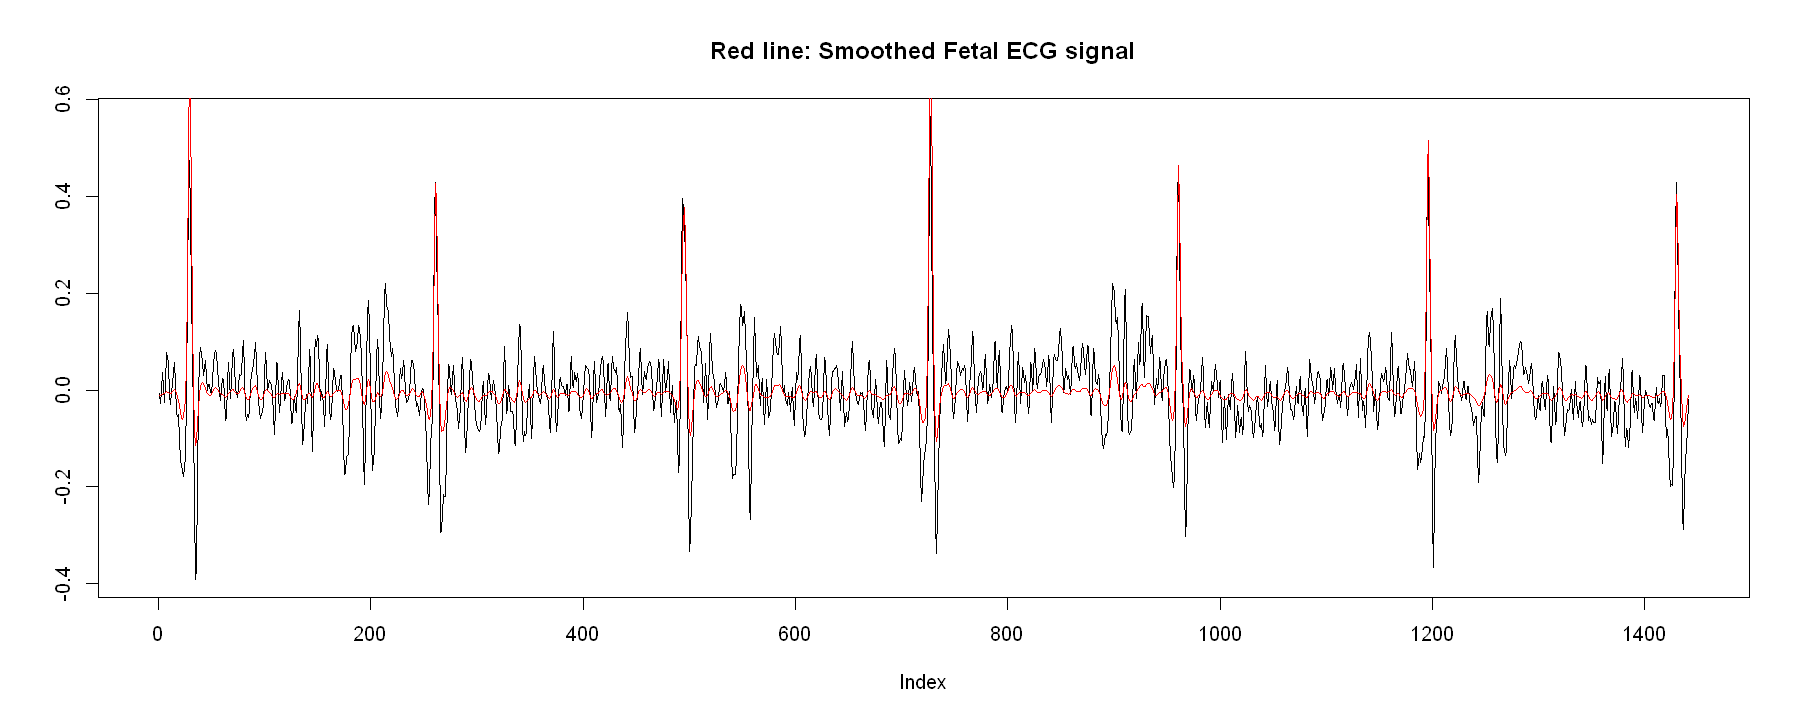

In [8]:
#filter fetal ECG for smoothing
lm_coef = lm( fetal[(1+BandWidth):(length(fetal)-BandWidth) ]~ filter2 )$coefficients
fetal_smooth = lm_coef[1]+ lm_coef[2]*filter2

plot( fetal[(1+BandWidth):(length(fetal)-BandWidth)] ,type = "l", ylab = '',main = "Red line: Smoothed Fetal ECG signal")
lines(fetal_smooth, type = "l",col = 2)

The plot above illustrates the effectiveness of our filtering technique in removing high-frequency noise. Next, we will conduct a comparative analysis between the filtered reconstruction and the original data. This comparison aims to assess the fidelity and accuracy of the filtering process.

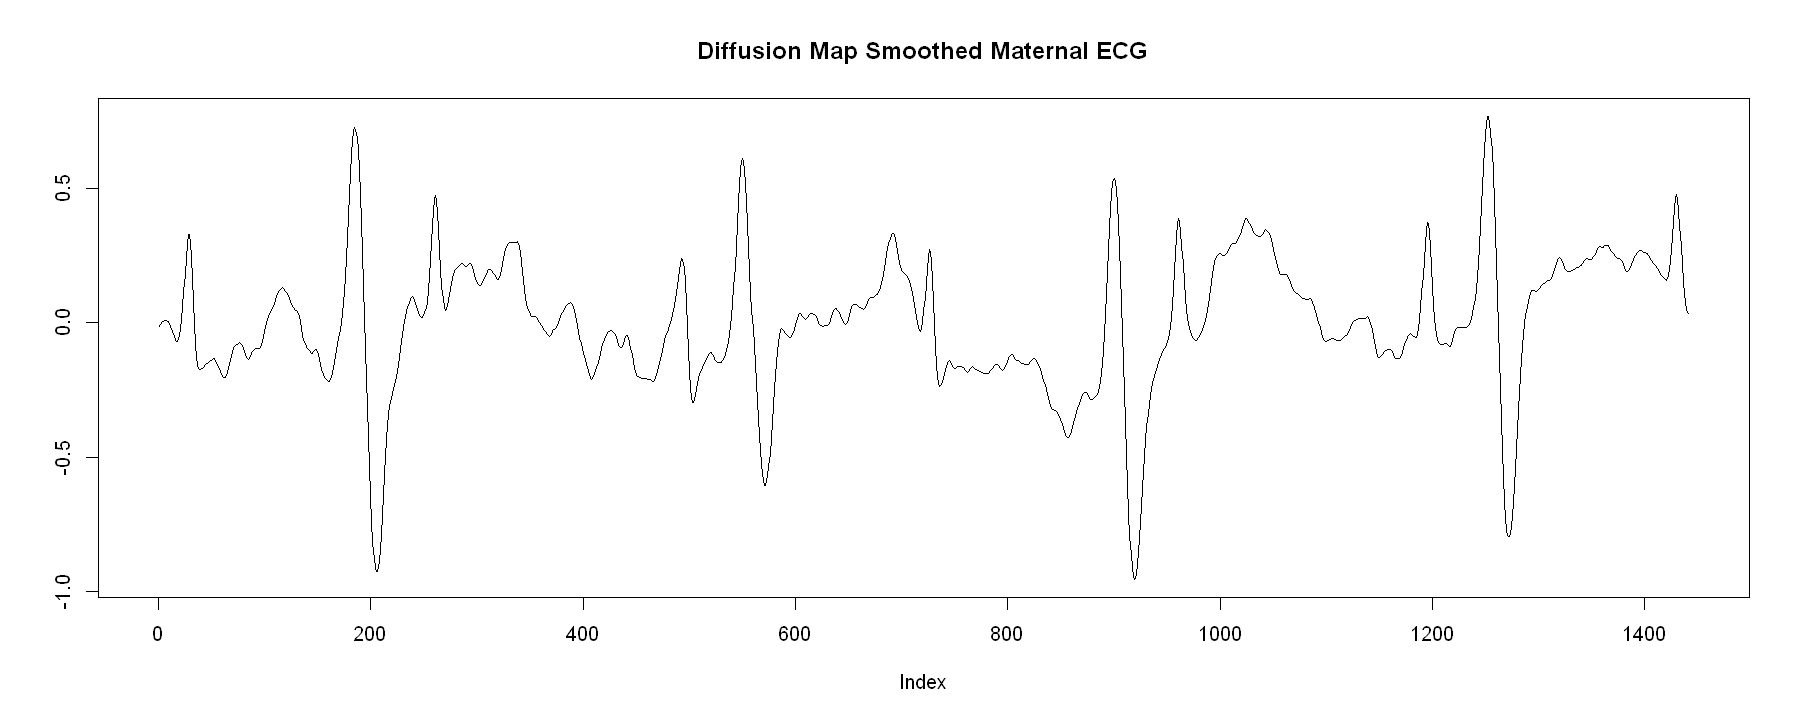

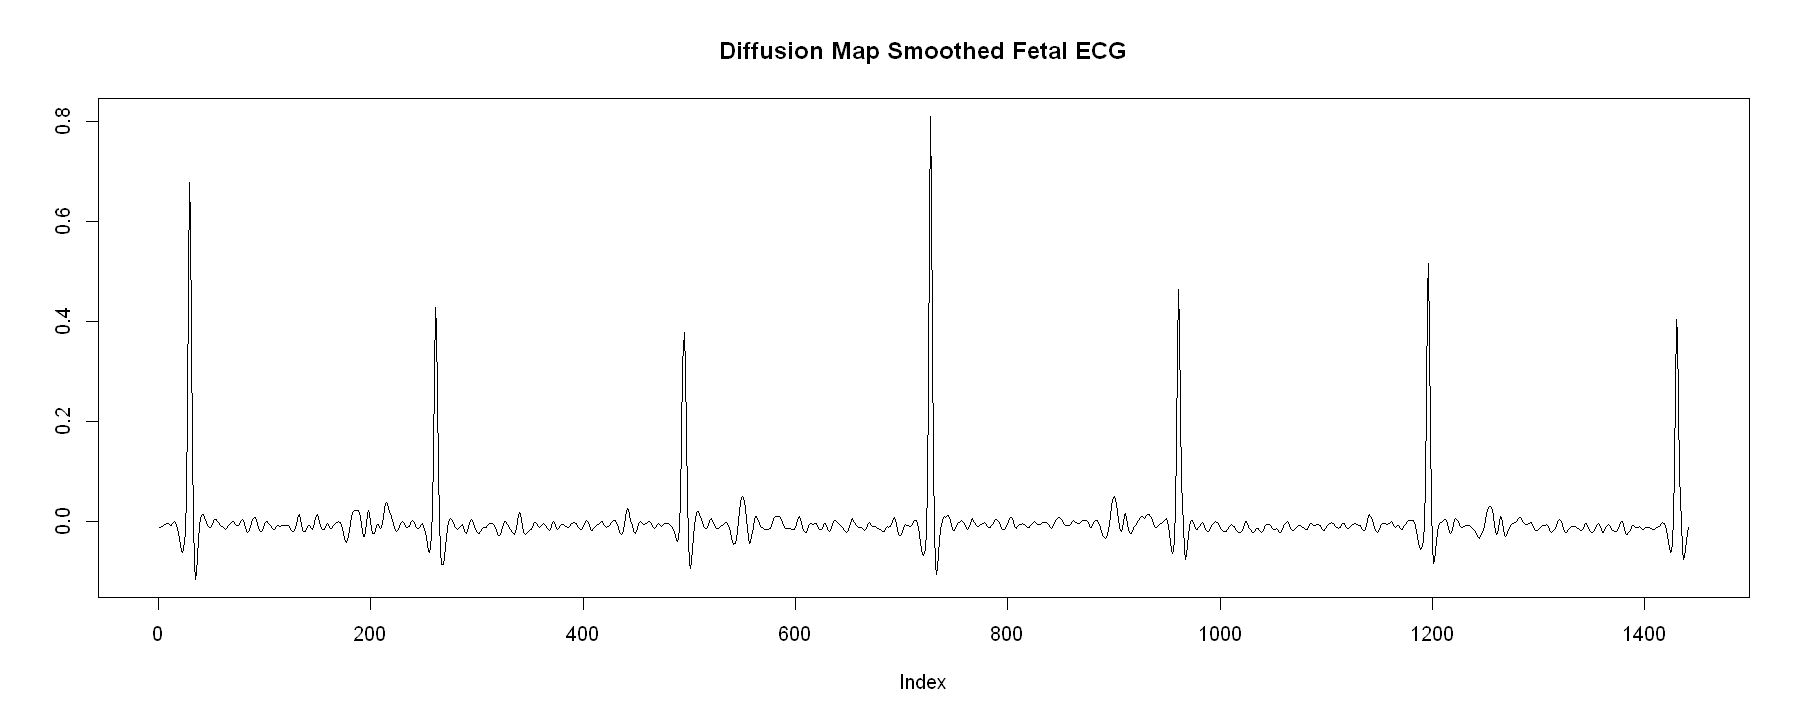

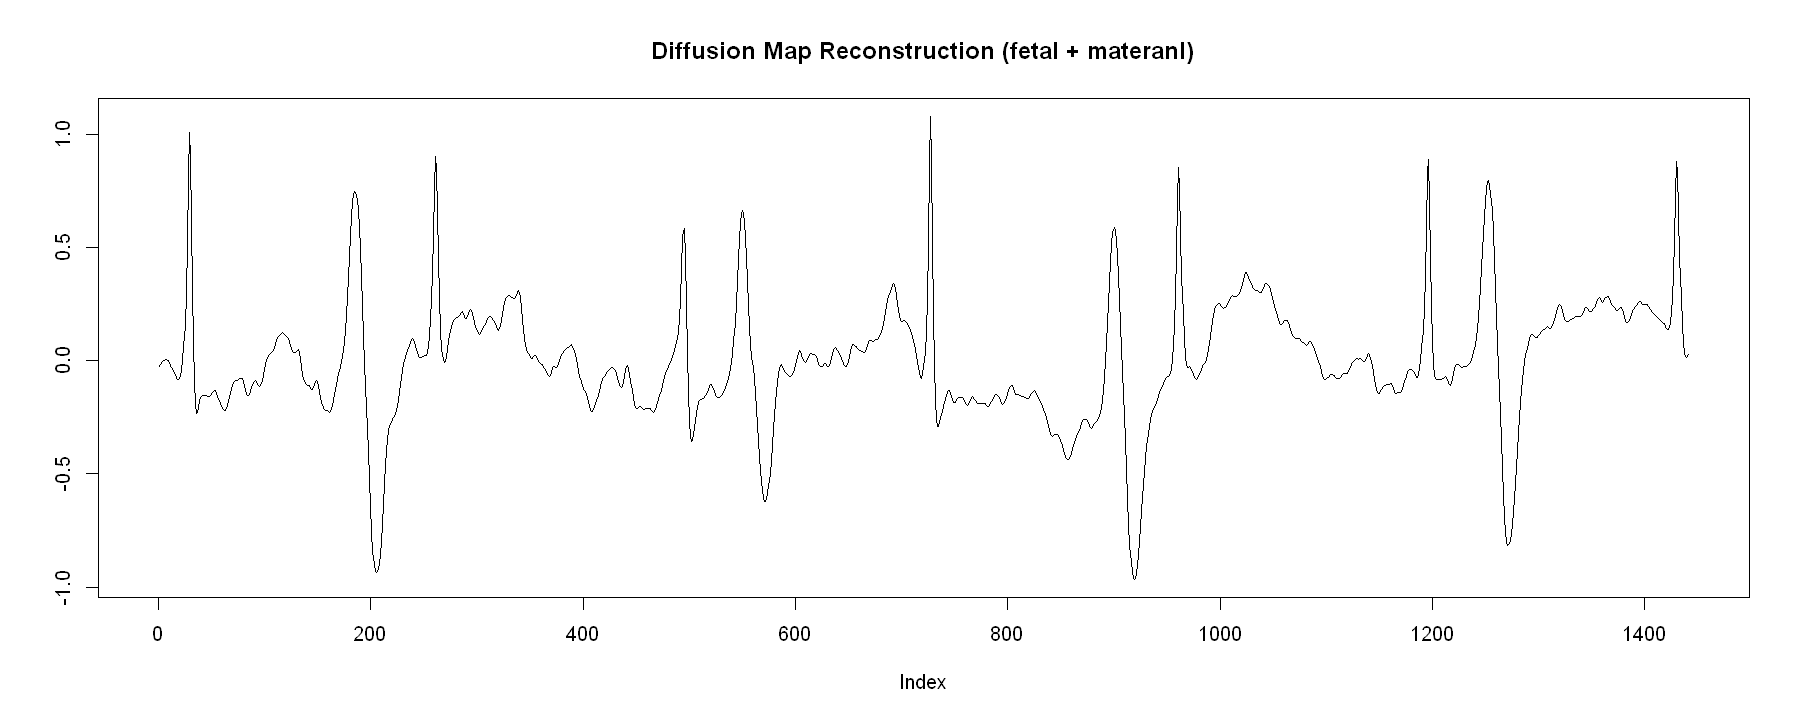

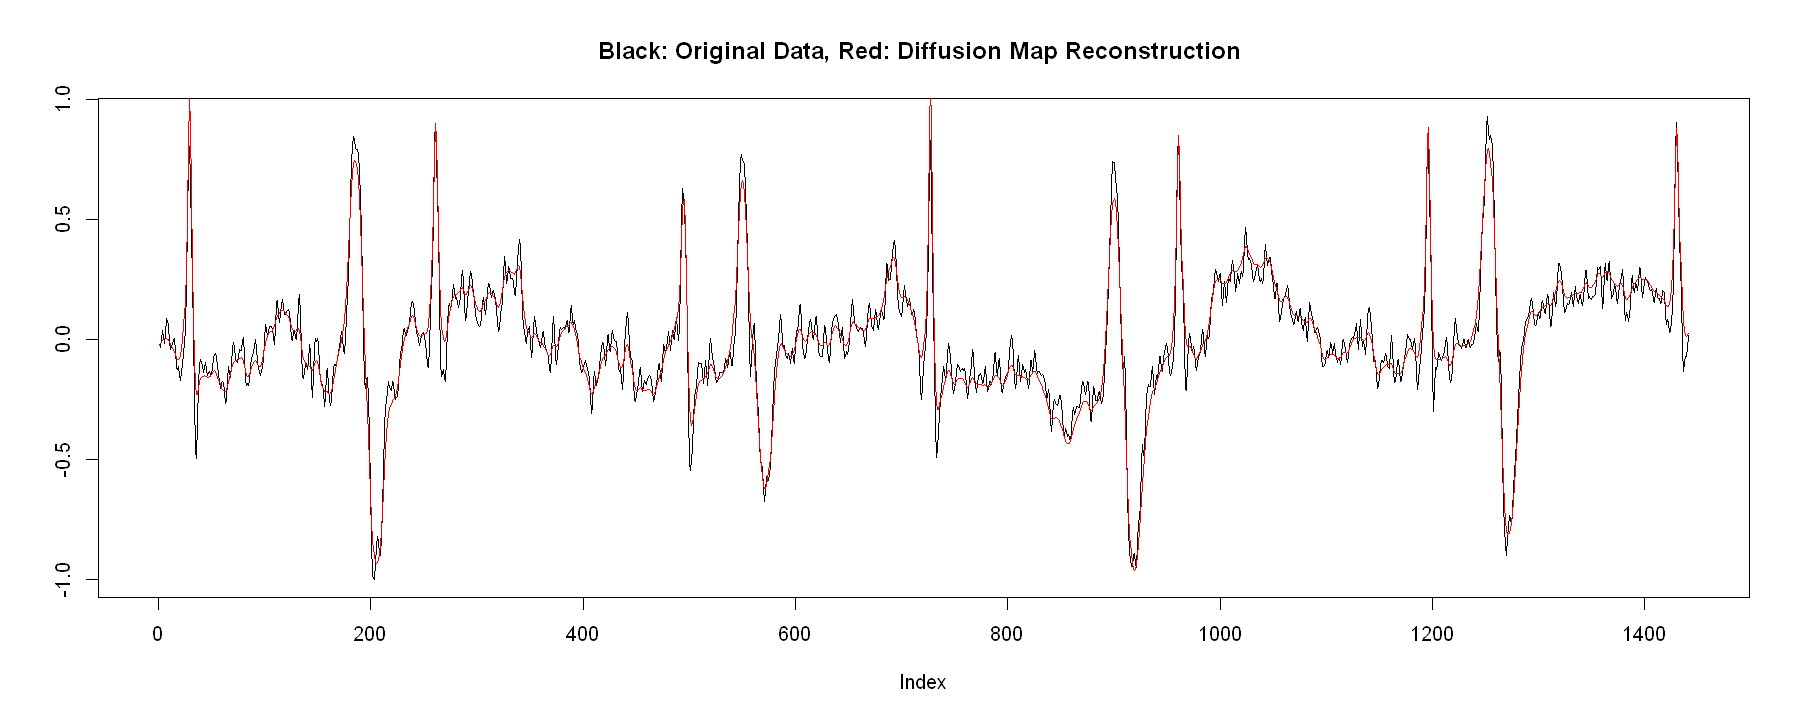

In [14]:
plot(maternal[(1+BandWidth):(length(maternal)-BandWidth) ], type = "l" , ylab = '', 
     main = "Diffusion Map Smoothed Maternal ECG")
plot(fetal_smooth, type = "l" , ylab = '', main = "Diffusion Map Smoothed Fetal ECG")
plot(maternal[(1+BandWidth):(length(maternal)-BandWidth) ] + fetal_smooth, type = "l" , ylab = '', 
     main = "Diffusion Map Reconstruction (fetal + materanl)")
plot(data[(1+2*BandWidth):(length(data)-2*BandWidth) ], type = "l" , ylab = '',
     main = "Black: Original Data, Red: Diffusion Map Reconstruction ")
lines(maternal[(1+BandWidth):(length(maternal)-BandWidth) ] + fetal_smooth, type = "l" , ylab = '', col = 2,
     main = "Diffusion Map Reconstruction (fetal + materanl)")

The smooth reconstruction achieved using the Diffusion Map method aligns well with the original data, effectively preserving key structural anomalies. While primarily known as a dimensionality reduction tool, the Diffusion Map's proficiency in unsupervised learning is notable, especially in its capability to isolate specific geometric features.